# 0 Configuration

In [459]:
config = {
    "overview": {
        "overview_plot": False
    },
    "cleaning": {
        "emptyness": {
            "overview_plot": False,
            "remove_empty": True
        },
        "types": {
            "convert": True
        },
        "categoricals": {
            "overview_plot": False,
            "usability": {
                "remove": True
            },
            "inconsistencies": {
                "strip_and_lower": True
            }
        },
        "numericals": {
            "overview_plot": False,
            "usability": {
                "remove": True
            },
            "redundancy": {
                "overview_plot": False,
                "distrib_corr_plot": False,
                "remove": True
            },
            "outliers": {
                "remove": False,
                "iqr_remove": False,
                "supplied_remove": True,
                "plot": False,
            },
            "scaling": {
                "distrib_plot_pre": False,
                "scale": True,
                "distrib_plot_post": False,
            }
        }
    },
    "correlations": {
        "numericals": {
            "overview_heatmap_plot": True,
            "removing": False,
            "result_heatmap_plot": True
        },
        "categoricals": {
            "labelisation": True,
            "overview_heatmap_plot": True,
            "removing": False,
            "result_heatmap_plot": True
        }
    },
    "final": {
        "overview_plot": False
    }
}

***
# 1 Dependency import

In [460]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fuzzywuzzy import process
import chardet

from math import ceil

from sklearn.preprocessing import minmax_scale, power_transform

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(0)

In [461]:
def dataframe_distribution_overview(data, figsize=(10, 3)):
    plt.figure(figsize=figsize)

    sns.barplot(x=data.columns, y=data.count())

    plt.title("Number of values per column", size=20)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.ylabel("Number values", size=16)
    plt.show()

In [462]:
def index_lth(data, percentage: int):
    percentage = percentage / 100
    less_than = data.count() < data.shape[0] * percentage
    index_less_than = less_than[less_than == True].index
    return index_less_than

In [463]:
def multi_plot_numerical(data, features, kind="hist", n_cols=8, figsize=(30, 10), wspace=0.35, hspace=0.35):
    feature_nb = len(features)
    n_rows = ceil(feature_nb / n_cols)
    index = 0

    plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    for r in range(n_rows):
        for c in range(n_cols):
            if index >= feature_nb:
                break

            plt.subplot(n_rows, n_cols, index+1)

            feature = features[index]

            if kind == "box":
                plot = sns.boxplot(y=data[feature])
            elif kind == "hist":
                plot = sns.histplot(data=data[feature], kde=True)
            else:
                plot = sns.histplot(data=data[feature], kde=True)

            plot.set_xlabel(feature, fontsize=12)
            plot.set_ylabel(None)

            index += 1

    plt.show()

In [464]:
def create_subplot(dataset, feature, n_rows, index, is_numeric):
    plt.subplot(n_rows, 2, index)
    uniques = dataset[feature].unique()

    if is_numeric:
        plot = sns.boxplot(y=dataset[feature])
    else:
        if uniques.size <= 20 and uniques.size > 0:
            plot = sns.countplot(x=dataset[feature])
            plt.xticks(rotation=45, size=8, ha="right")
        else:
            dist = pd.DataFrame(data=[[uniques.size, dataset.shape[0] - uniques.size]], columns=["uniques", "not_uniques"])
            plot = sns.barplot(data=dist)

    plot.set_xlabel(None)
    plot.set_ylabel(feature, fontsize=14)


def dataset_diff_analysis(data1, data2, exclude=[], figsize=(15, 200)):
    features = data1.columns.union(data2.columns).difference(exclude)
    n_cols = 2
    n_rows = len(features)
    col_id = 0
    index = 1

    plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=0.35, hspace=0.5)

    for f in features:
        is_numeric = False
        if f in data1.columns:
            f_type = data1[f].dtype
        else:
            f_type = data2[f].dtype
        if f_type in ["int64", "float64"]:
            is_numeric = True

        if f in data1.columns.values:
            create_subplot(data1, f, n_rows, index, is_numeric)
        if f in data2.columns.values:
            create_subplot(data2, f, n_rows, index+1, is_numeric)

        index += 2

    print(f"features: {features}")
    plt.show()

In [465]:
def decribe_several(feature, *df):
    data = {}
    index = 1
    for d in df:
        data[feature + "_" + str(index)] = d[feature]
        index += 1
    final_dataframe = pd.DataFrame(data)
    return final_dataframe.describe()

In [466]:
def head_several(feature, nb, *df):
    data = {}
    index = 1
    for d in df:
        data[feature + "_" + str(index)] = d[feature]
        index += 1
    final_dataframe = pd.DataFrame(data)
    return final_dataframe.head(nb)

In [467]:
class OutlierProcessor():
    def __init__(self, data, features, lower_trig, upper_trig):
        self.data = data
        self.features = features
        self.lower_trig = lower_trig
        self.upper_trig = upper_trig
        self.__above = 0
        self.__below = 0
        self.__total = 0

    def __print(self):
        print(f"lower_trig: {self.lower_trig}")
        print(f"upper_trig: {self.upper_trig}")
        print(f"below: {self.__below}")
        print(f"above: {self.__above}")
        print(f"total: {self.__total}")

    def analyse(self):
        self.__below = self.data[self.data[self.features] < self.lower_trig][self.features].count()
        self.__above = self.data[self.data[self.features] > self.upper_trig][self.features].count()
        self.__total = self.__below + self.__above
        self.__print()

    def replace(self, replace_by=np.nan, inplace=False):
        result = self.data.loc[:, self.features].where(cond=lambda x: ((x > self.lower_trig) & (self.upper_trig > x)), other=replace_by)
        if inplace:
            self.data[self.features] = result
        else:
            return result



In [468]:
class OutlierIqrProcessor(OutlierProcessor):
    def __init__(self, data, features, exclude=None):
        self.features = [feature for feature in features if feature not in exclude]
        self.__q1 = data[self.features].quantile(0.25)
        self.__q3 = data[self.features].quantile(0.75)
        self.__iqr = self.__q3 - self.__q1
        upper_trig = self.__q3 + (1.5 * self.__iqr)
        lower_trig = self.__q1 - (1.5 * self.__iqr)
        super().__init__(data, self.features, lower_trig, upper_trig)


In [469]:
def correlation_heatmap(dataset, figsize=(30, 20)):
    plt.figure(figsize=figsize)

    correlation = dataset.corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    sns.heatmap(data=correlation, mask=mask, annot=True, vmax=.75, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title("Correlation heatmap", size=20)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.show()

In [470]:
def unique_several(dataset, features, take=20):
    uniques_data = {}
    too_many_uniques = []
    only_one_uniques = []
    only_two_uniques = []

    for f in features:
        f_uniques = dataset[f].unique()
        if f_uniques.size <= take:
            if f_uniques.size == 1:
                only_one_uniques.append(f)
            elif f_uniques.size == 2:
                only_two_uniques.append(f)
            else:
                uniques_data[f] = pd.Series(data=f_uniques, name=f, dtype="object")
        else:
            too_many_uniques.append((f, f_uniques.size))

    print(f"Only one unique: {only_one_uniques}")
    print(f"Only two uniques: {only_two_uniques}")
    print(f"Too many uniques: {too_many_uniques}")

    return pd.DataFrame(data=uniques_data)

In [471]:
def strip_and_lower(dataset, features, to_strip=None, inplace=False):
    result_data = {}
    for f in features:
        result_data[f] = pd.Series(data=dataset[f].str.strip(to_strip=to_strip), name=f, dtype="object")
        result_data[f] = result_data[f].str.lower()
    result = pd.DataFrame(data=result_data)
    if inplace:
        dataset[features] = result
    else:
        return result

In [472]:
def fuzzy_matching_several(dataset, fuzzy, limit=10):
    fuzzy_data = {}
    for feature, match in fuzzy:
        fuzzy_matches = fuzzywuzzy.process.extract(match, dataset[feature], limit=limit, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
        fuzzy_data[feature] = pd.Series(data=fuzzy_matches, name=feature, dtype="object")
    return pd.DataFrame(data=fuzzy_data)

In [473]:
def feature_distribution_multivar(data, features, figsize=(10, 3), wspace=0.2, hspace=0.2, corr_scale=(0.75, 0), xlim=(None, None), ylim=(None, None)):
    plt.subplots(1, 2, figsize=figsize)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    plt.subplot(1, 2, 1)
    for f in features:
        plot = sns.kdeplot(data=data[f], label=f, shade=True)

    plt.title(f"Distribution", size=20)
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlim(xlim[0], xlim[1])
    plt.ylim(ylim[0], ylim[1])
    plt.xlabel(None)
    plt.ylabel("Density", size=16)
    plt.legend()

    plt.subplot(1, 2, 2)
    correlation = data.loc[:, features].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))

    sns.heatmap(data=correlation, mask=mask, annot=True, vmax=corr_scale[0], center=corr_scale[1],
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

    plt.title(f"Correlation", size=20)
    plt.xticks(rotation=45, size=12, ha="right")
    plt.yticks(rotation=0, size=12, va="center")
    
    plt.show()


***
# 2 Data loading

In [474]:
data = pd.read_csv("data/2016-building-energy-benchmarking.csv", delimiter=",")

***
# 3 Overview

In [475]:
if config["overview"]["overview_plot"]:
    dataframe_distribution_overview(data, figsize=(30, 3))

In [476]:
targets = ["SiteEnergyUse(kBtu)", "GHGEmissionsIntensity"]

***
# 4 Cleaning

***
## 4.1 Emptyness

In [477]:
cols_to_remove = index_lth(data, 10).difference(["Outlier"])

In [478]:
if config["cleaning"]["emptyness"]["remove_empty"]:
    data.drop(columns=cols_to_remove, inplace=True)

In [479]:
if config["cleaning"]["emptyness"]["overview_plot"]:
    dataframe_distribution_overview(data, figsize=(30, 3))

***
## 4.2 Types

In [480]:
data.describe(include="object")

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ComplianceStatus,Outlier
count,3376,3376,3376,3376,3376,3376,3376,3376,3367,3356,1679,596,3376,32
unique,8,24,3362,3354,1,1,3268,19,466,56,50,44,4,2
top,NonResidential,Low-Rise Multifamily,Northgate Plaza,2600 SW Barton St,Seattle,WA,1625049001,DOWNTOWN,Multifamily Housing,Multifamily Housing,Parking,Retail Store,Compliant,Low outlier
freq,1460,987,3,4,3376,3376,8,573,866,1667,976,110,3211,23


In [481]:
data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000


In [482]:
if config["cleaning"]["types"]["convert"]:
    data["TaxParcelIdentificationNumber"] = pd.to_numeric(data["TaxParcelIdentificationNumber"], errors="coerce")
    data["TaxParcelIdentificationNumber"].describe()

***
## 4.3 Categoricals

### 4.3.1 Overview

In [483]:
categorical_data = data.select_dtypes("object").columns

In [484]:
data[categorical_data].describe()

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ComplianceStatus,Outlier
count,3376,3376,3376,3376,3376,3376,3376,3367,3356,1679,596,3376,32
unique,8,24,3362,3354,1,1,19,466,56,50,44,4,2
top,NonResidential,Low-Rise Multifamily,Northgate Plaza,2600 SW Barton St,Seattle,WA,DOWNTOWN,Multifamily Housing,Multifamily Housing,Parking,Retail Store,Compliant,Low outlier
freq,1460,987,3,4,3376,3376,573,866,1667,976,110,3211,23


***
### 4.3.2 Usability

The features "City" and "State" are always the same. They bring no usefull information.

In [485]:
if config["cleaning"]["categoricals"]["usability"]["remove"]:
    features_to_delete = ["City", "State"]
    data.drop(columns=features_to_delete, inplace=True)
    categorical_data = categorical_data.drop(features_to_delete)

***
### 4.3.3 Inconsistencies

In [486]:
unique_several(data, categorical_data, take=50)

Only one unique: []
Only two uniques: []
Too many uniques: [('PropertyName', 3362), ('Address', 3354), ('ListOfAllPropertyUseTypes', 467), ('LargestPropertyUseType', 57), ('SecondLargestPropertyUseType', 51)]


,BuildingType,PrimaryPropertyType,Neighborhood,ThirdLargestPropertyUseType,ComplianceStatus,Outlier
0,NonResidential,Hotel,DOWNTOWN,NaN,Compliant,NaN
1,Nonresidential COS,Other,SOUTHEAST,Restaurant,Error - Correct Default Data,High outlier
2,Multifamily MR (5-9),Mid-Rise Multifamily,NORTHEAST,Swimming Pool,Missing Data,Low outlier
3,SPS-District K-12,Mixed Use Property,EAST,Data Center,Non-Compliant,NaN
4,Campus,K-12 School,Central,Office,NaN,NaN
5,Multifamily LR (1-4),University,NORTH,Retail Store,NaN,NaN
6,Multifamily HR (10+),Small- and Mid-Sized Office,MAGNOLIA / QUEEN ANNE,Other - Entertainment/Public Assembly,NaN,NaN
7,Nonresidential WA,Self-Storage Facility,LAKE UNION,Non-Refrigerated Warehouse,NaN,NaN
8,NaN,Warehouse,GREATER DUWAMISH,Other,NaN,NaN
9,NaN,Large Office,BALLARD,Distribution Center,NaN,NaN


In [487]:
if config["cleaning"]["categoricals"]["inconsistencies"]["strip_and_lower"]:
    strip_and_lower(data, categorical_data, inplace=True)
    unique_several(data, categorical_data, take=50)

Only one unique: []
Only two uniques: []
Too many uniques: [('PropertyName', 3360), ('Address', 3353), ('ListOfAllPropertyUseTypes', 467), ('LargestPropertyUseType', 57), ('SecondLargestPropertyUseType', 51)]


In [488]:
# fuzzy = [
#     ("Neighborhood_2016", "Ballard"),
# ]
# fuzzy_matching_several(data)

***
## 4.4 Numericals

### 4.4.1 Overview

In [489]:
numerical_data = data.select_dtypes(["int64", "float64"]).columns

In [490]:
data[numerical_data].describe()

,OSEBuildingID,DataYear,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3.373000e+03,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.297012e+09,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.960847e+09,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,538.832227,1.821452
min,1.000000,2016.0,98006.000000,0.000000e+00,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,1.975701e+09,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,3.524039e+09,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.129302e+09,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,5.569640e+10,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000


In [491]:
if config["cleaning"]["numericals"]["overview_plot"]:
    multi_plot_numerical(data, numerical_data, kind="box", n_cols=6, hspace=0.4, wspace=0.30, figsize=(30, 25))

***
### 4.4.2 Usability

In [492]:
data[numerical_data].describe()

,OSEBuildingID,DataYear,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3.373000e+03,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.297012e+09,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.960847e+09,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,538.832227,1.821452
min,1.000000,2016.0,98006.000000,0.000000e+00,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,1.975701e+09,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,3.524039e+09,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.129302e+09,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,5.569640e+10,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,16870.980000,34.090000


In [493]:
if config["cleaning"]["numericals"]["usability"]["remove"]:
    features_to_delete = ["DataYear"]
    data.drop(columns=features_to_delete, inplace=True)
    numerical_data = numerical_data.drop(features_to_delete)

***
### 4.4.2 Redundancy

In [494]:
if config["cleaning"]["numericals"]["redundancy"]["overview_plot"]:
    dataframe_distribution_overview(data[numerical_data], figsize=(25, 3))

***
#### 4.4.2.1 SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf)

In [495]:
features = ["SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)"]

In [496]:
if config["cleaning"]["numericals"]["redundancy"]["distrib_corr_plot"]:
    feature_distribution_multivar(data, features, figsize=(15, 5), hspace=0.2, wspace=0.75, corr_scale=(1, 0), xlim=(-50, 300))

In [497]:
if config["cleaning"]["numericals"]["redundancy"]["remove"]:
    features_to_delete = ["SiteEUIWN(kBtu/sf)"]
    data.drop(columns=features_to_delete, inplace=True)
    numerical_data = numerical_data.drop(features_to_delete)

***
#### 4.4.2.2 SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf)

In [498]:
features = ["SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)"]

In [499]:
if config["cleaning"]["numericals"]["redundancy"]["distrib_corr_plot"]:
    feature_distribution_multivar(data, features, figsize=(15, 5), hspace=0.2, wspace=0.75, corr_scale=(1, 0), xlim=(-100, 800))

In [500]:
if config["cleaning"]["numericals"]["redundancy"]["remove"]:
    features_to_delete = ["SourceEUIWN(kBtu/sf)"]
    data.drop(columns=features_to_delete, inplace=True)
    numerical_data = numerical_data.drop(features_to_delete)

***
#### 4.4.2.3 SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu)

In [501]:
features = ["SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)"]

In [502]:
if config["cleaning"]["numericals"]["redundancy"]["distrib_corr_plot"]:
    feature_distribution_multivar(data, features, figsize=(15, 5), hspace=0.2, wspace=0.75, corr_scale=(1, 0), xlim=(-0.15e8, 0.35e8))

In [503]:
if config["cleaning"]["numericals"]["redundancy"]["remove"]:
    features_to_delete = ["SiteEnergyUseWN(kBtu)"]
    data.drop(columns=features_to_delete, inplace=True)
    numerical_data = numerical_data.drop(features_to_delete)

***
#### 4.4.2.4 Electricity(kWh), Electricity(kBtu)

In [504]:
features = ["Electricity(kWh)", "Electricity(kBtu)"]

In [505]:
if config["cleaning"]["numericals"]["redundancy"]["distrib_corr_plot"]:
    feature_distribution_multivar(data, features, figsize=(15, 5), hspace=0.2, wspace=0.75, corr_scale=(1, 0), xlim=(-1e7, 1.5e7))

In [506]:
if config["cleaning"]["numericals"]["redundancy"]["remove"]:
    features_to_delete = ["Electricity(kBtu)"]
    data.drop(columns=features_to_delete, inplace=True)
    numerical_data = numerical_data.drop(features_to_delete)

***
#### 4.4.2.5 NaturalGas(therms), NaturalGas(kBtu)

In [507]:
features = ["NaturalGas(therms)", "NaturalGas(kBtu)"]

In [508]:
if config["cleaning"]["numericals"]["redundancy"]["distrib_corr_plot"]:
    feature_distribution_multivar(data, features, figsize=(15, 5), hspace=0.2, wspace=0.75, corr_scale=(1, 0), xlim=(-2, 5))

In [509]:
data[features].describe()

,NaturalGas(therms),NaturalGas(kBtu)
count,3.367000e+03,3.367000e+03
mean,1.368505e+04,1.368505e+06
std,6.709781e+04,6.709781e+06
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,3.237538e+03,3.237540e+05
75%,1.189033e+04,1.189034e+06
max,2.979090e+06,2.979090e+08


In [510]:
if config["cleaning"]["numericals"]["redundancy"]["remove"]:
    features_to_delete = ["NaturalGas(therms)"]
    data.drop(columns=features_to_delete, inplace=True)
    numerical_data = numerical_data.drop(features_to_delete)

***
### 4.3.2 Outliers removal

In [511]:
data[numerical_data].describe()

,OSEBuildingID,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3360.000000,3.373000e+03,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3367.000000,3.371000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3367.000000,3367.000000
mean,21208.991114,98116.949107,4.297012e+09,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,134.232848,5.403667e+06,2.745959e+05,1.086639e+06,1.368505e+06,119.723971,1.175916
std,12223.757015,18.615205,2.960847e+09,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,139.287554,2.161063e+07,3.912173e+06,4.352478e+06,6.709781e+06,538.832227,1.821452
min,1.000000,98006.000000,0.000000e+00,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,-3.382680e+04,0.000000e+00,-0.800000,-0.020000
25%,19990.750000,98105.000000,1.975701e+09,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,74.699997,9.251286e+05,0.000000e+00,1.874229e+05,0.000000e+00,9.495000,0.210000
50%,23112.000000,98115.000000,3.524039e+09,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,96.199997,1.803753e+06,0.000000e+00,3.451299e+05,3.237540e+05,33.920000,0.610000
75%,25994.250000,98122.000000,7.129302e+09,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,143.899994,4.222455e+06,0.000000e+00,8.293178e+05,1.189034e+06,93.940000,1.370000
max,50226.000000,98272.000000,5.569640e+10,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,2620.000000,8.739237e+08,1.349435e+08,1.925775e+08,2.979090e+08,16870.980000,34.090000


In [512]:
values = data[numerical_data].idxmax().value_counts()
data.loc[values[values > 3].index]

,OSEBuildingID,BuildingType,PrimaryPropertyType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3274,49967,campus,university,university of washington - seattle campus,ne 45th st & brooklyn ave,98105.0,1.625049e+09,4,northeast,47.65644,-122.31041,1900,111.0,0,9320156,0,9320156,college/university,college/university,9320156.0,NaN,NaN,NaN,NaN,NaN,93.800003,246.600006,873923712.0,84985240.0,192577488.0,0.0,False,compliant,NaN,11140.56,1.20
35,43,campus,mixed use property,plant 2 site,7755 e marginal way s,98108.0,2.200000e+07,2,greater duwamish,47.53493,-122.31788,1992,1.0,3,494835,0,494835,"energy/power station, laboratory, manufacturin...",office,757027.0,laboratory,639931.0,non-refrigerated warehouse,459748.0,8.0,221.699997,388.200012,448385312.0,0.0,44102076.0,297909000.0,False,compliant,NaN,16870.98,34.09


In [513]:
if config["cleaning"]["numericals"]["outliers"]["remove"]:
    data.drop(index=values[values > 3].index, inplace=True)

In [514]:
if config["cleaning"]["numericals"]["outliers"]["iqr_remove"]:
    o_proc = OutlierIqrProcessor(data, numerical_data, exclude=["Latitude", "Longitude"])
    temp = o_proc.replace(inplace=True)


In [515]:
if config["cleaning"]["numericals"]["outliers"]["supplied_remove"]:
    outliers_index = data[data["Outlier"].notna()].index
    data.drop(index=outliers_index, inplace=True)

features_to_delete = ["Outlier"]
data.drop(columns=features_to_delete, inplace=True)
categorical_data = categorical_data.drop(features_to_delete)

In [516]:
if config["cleaning"]["numericals"]["outliers"]["plot"]:
    multi_plot_numerical(data, numerical_data, kind="box", n_cols=6, hspace=0.4, wspace=0.30, figsize=(30, 25))

***
### 4.3.3 Scaling

In [517]:
if config["cleaning"]["numericals"]["scaling"]["distrib_plot_pre"]:
    multi_plot_numerical(data, numerical_data, n_cols=5, hspace=0.4, wspace=0.2, figsize=(30, 50))

In [518]:
if config["cleaning"]["numericals"]["scaling"]["scale"]:
    data[numerical_data] = pd.DataFrame(data=minmax_scale(data[numerical_data], feature_range=(0, 100)), columns=numerical_data)
    # data[numerical_data] = pd.DataFrame(data=power_transform(data[numerical_data]), columns=numerical_data)
    data[numerical_data].head()

In [519]:
if config["cleaning"]["numericals"]["scaling"]["distrib_plot_post"]:
    multi_plot_numerical(data, numerical_data, n_cols=5, hspace=0.4, wspace=0.2, figsize=(30, 50))

***
## 4.5 Targets

### 4.5.1 Nan removing

In [520]:
data[targets].isna().any()

SiteEnergyUse(kBtu)      True
GHGEmissionsIntensity    True
dtype: bool

In [521]:
data.dropna(subset=targets, inplace=True)

In [522]:
data[targets].isna().any()

SiteEnergyUse(kBtu)      False
GHGEmissionsIntensity    False
dtype: bool

***
### 4.5.2 Normalization

In [523]:
targets

['SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity']

In [539]:
data[targets].describe()

,SiteEnergyUse(kBtu),GHGEmissionsIntensity
count,3264.000000,3264.000000
mean,0.003034,0.001805
std,1.002625,1.000490
min,-1.765320,-2.281096
25%,-0.841459,-0.976494
50%,-0.226584,0.033648
75%,0.757402,0.803694
max,2.071119,2.435910


In [538]:
# feature = data.ZipCode.array.reshape(-1, 1)
target_transformed = pd.DataFrame(data=power_transform(data[targets], method="box-cox"), columns=data[targets].columns)

ValueError: The Box-Cox transformation can only be applied to strictly positive data

In [525]:
target_transformed.head()

,SiteEnergyUse(kBtu),GHGEmissionsIntensity
0,1.321635,1.394246
1,1.451516,1.401760
2,2.062036,1.201859
3,1.263834,1.716607
4,1.789498,1.406708


In [537]:
target_transformed.describe()

,SiteEnergyUse(kBtu),GHGEmissionsIntensity
count,3.303000e+03,3.303000e+03
mean,2.736735e-16,-1.667855e-16
std,1.000151e+00,1.000151e+00
min,-1.765320e+00,-2.281096e+00
25%,-8.403921e-01,-9.764942e-01
50%,-2.305166e-01,3.364824e-02
75%,7.516890e-01,8.036944e-01
max,2.071119e+00,2.435910e+00


In [526]:
data[targets] = target_transformed

***
# 5 Correlations

## 5.1 Numericals features

### 5.1.1 Overview

In [527]:
targets

['SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity']

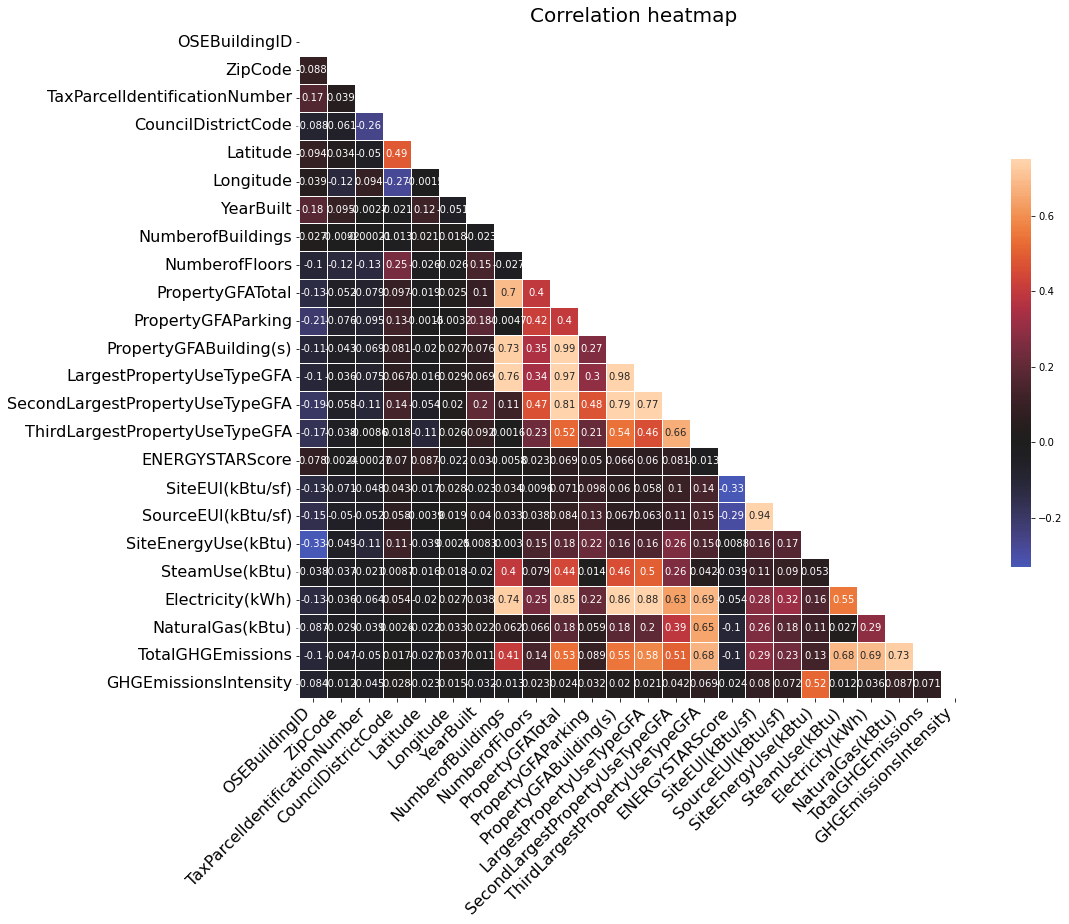

In [528]:
if config["correlations"]["numericals"]["overview_heatmap_plot"]:
    correlation_heatmap(data[numerical_data], figsize=(15, 15))

***
### 5.1.2 Removing

In [529]:
if config["correlations"]["numericals"]["removing"]:
    features_to_delete = []
    data.drop(columns=features_to_delete, inplace=True)
    numerical_data = numerical_data.drop(features_to_delete)

***
### 5.1.3 Result

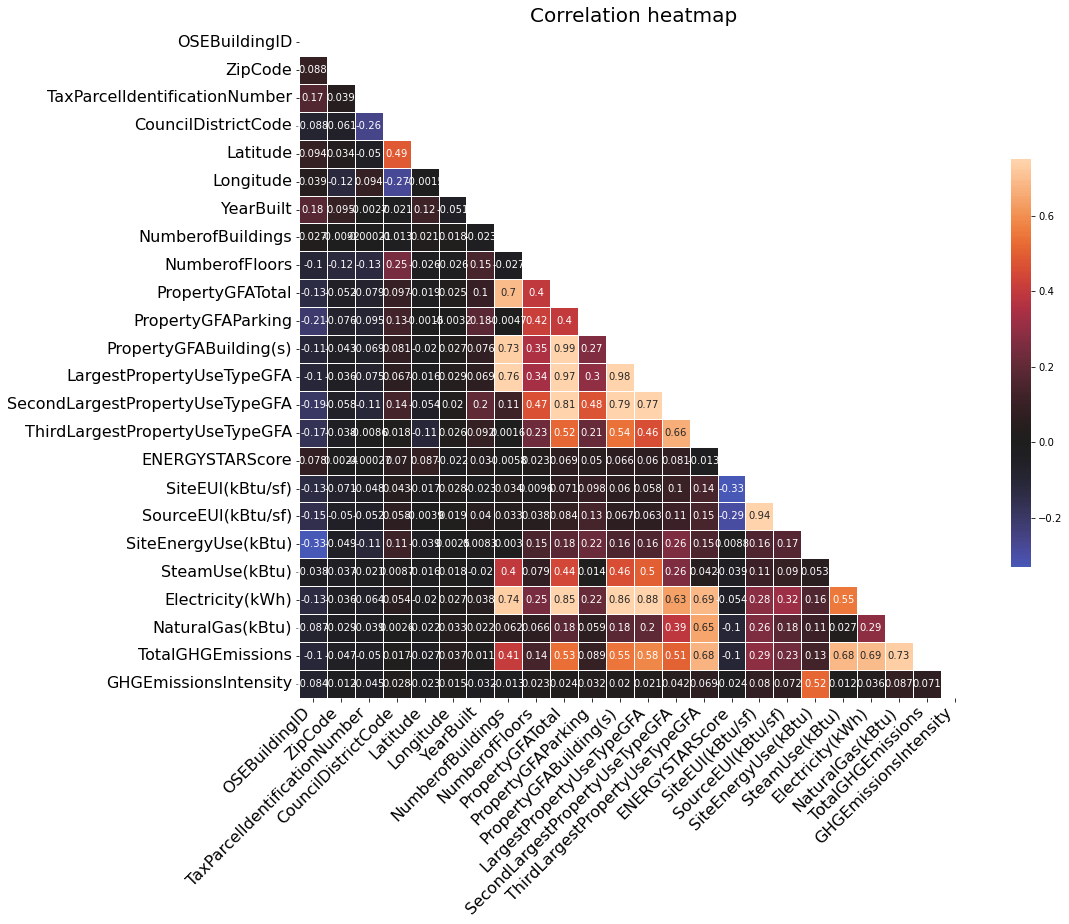

In [530]:
if config["correlations"]["numericals"]["result_heatmap_plot"]:
    correlation_heatmap(data[numerical_data], figsize=(15, 15))

***
## 5.2 Categoricals features

### 5.2.1 Labelisation

In [531]:
if config["correlations"]["categoricals"]["labelisation"]:
    categs_to_nums = data[categorical_data].apply(lambda feature: feature.astype("category").cat.codes)

    for col in categs_to_nums.columns:
        categs_to_nums.rename(columns={col: col + "_CATEG"}, inplace=True)

    data_enhanced = categs_to_nums.join(data[targets])

***
### 5.2.2 Overview

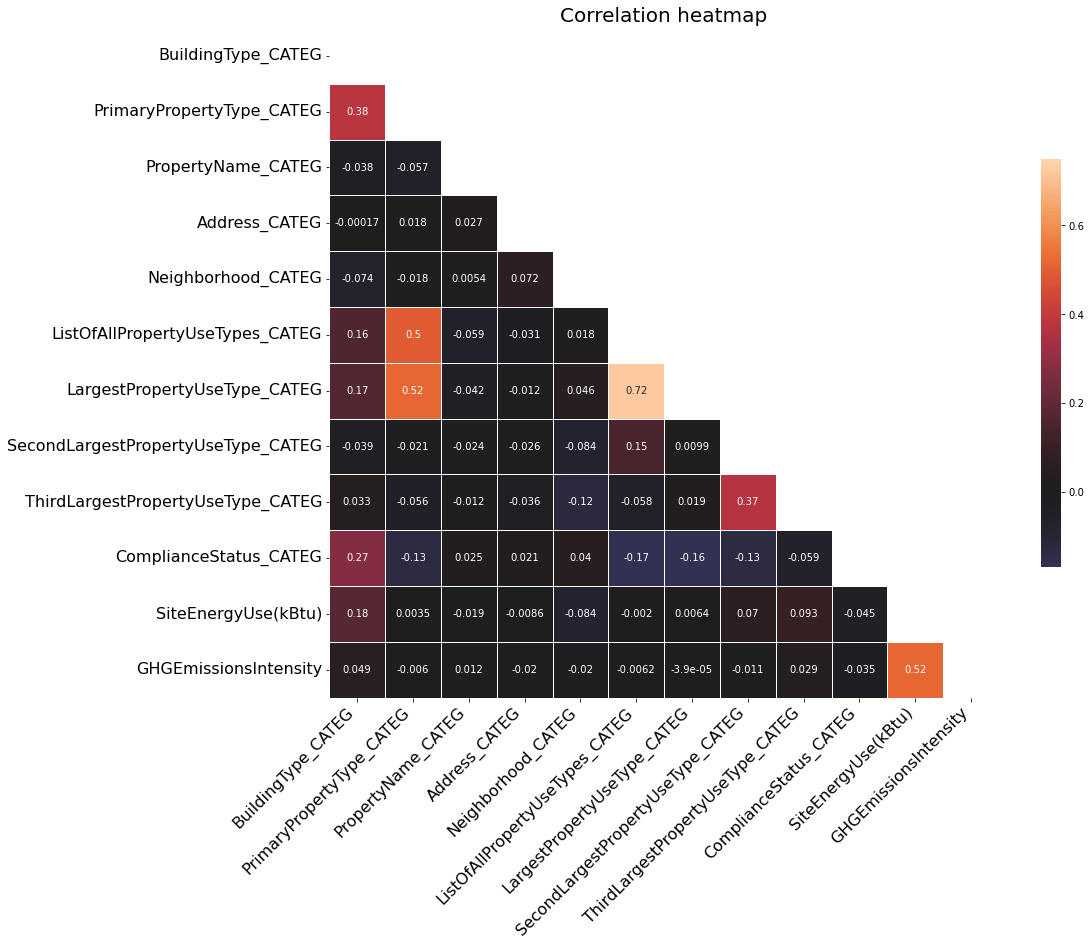

In [532]:
if config["correlations"]["categoricals"]["overview_heatmap_plot"]:
    correlation_heatmap(data_enhanced, figsize=(15, 15))

***
### 5.2.3 Removing

In [533]:
if config["correlations"]["categoricals"]["removing"]:
    features_to_delete = []
    data.drop(columns=features_to_delete, inplace=True)
    categorical_data = categorical_data.drop(features_to_delete)

***
### 5.2.4 Result

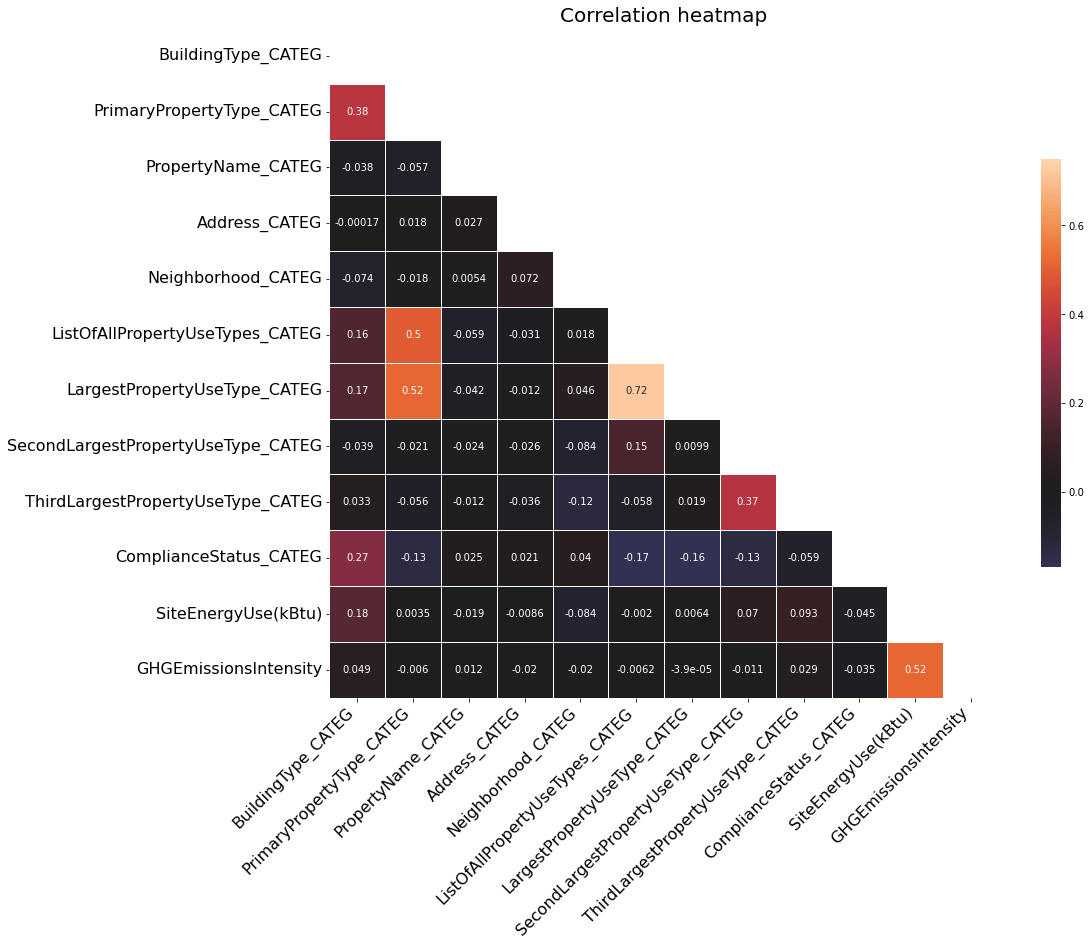

In [534]:
if config["correlations"]["categoricals"]["result_heatmap_plot"]:
    correlation_heatmap(data_enhanced, figsize=(15, 15))

***
# 6 Final state

In [535]:
if config["final"]["overview_plot"]:
    dataframe_distribution_overview(data, figsize=(30, 3))

***
# 7 Saving

In [536]:
data.to_csv("data/data-cleaned.csv", sep=",")